## Parse model config yaml file

In [1]:
from app.features.model.schema.configs import ModelConfig
import yaml
config = """name: GNNExample
dataset:
  name: test_dataset_2
  target_column: "tpsa"
  feature_columns:
    - smiles
    - mwt
featurizers:
  - name: MolToGraphFeaturizer
    type: app.features.model.featurizers.MoleculeFeaturizer
    input:
      - smiles
    args:
      allow_unknown: false
      sym_bond_list: true
      per_atom_fragmentation: false
layers:
  # Start fst branch (from featurizer)
  - name: GCN1
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 30
      out_channels: 64
    input: MolToGraphFeaturizer
  - name: GCN1_Activation
    type: torch.nn.ReLU
    input: GCN1
  - name: GCN2 
    type: torch_geometric.nn.GCNConv
    input: GCN1_Activation
    args:
      in_channels: 64
      out_channels: 64
  - name: GCN2_Activation
    type: torch.nn.ReLU
    input: GCN2
  - name: GCN3 # an arbitrary name 
    type: torch_geometric.nn.GCNConv
    input: GCN2_Activation
    args:
      in_channels: 64
      out_channels: 64
  - name: GCN3_Activation
    type: torch.nn.ReLU
    input: GCN3
  - name: AddPool
    type: app.features.model.layers.GlobalPooling
    input: GCN3_Activation
    args:
      aggr: 'sum'
    # End of fst branch
    # Second branch would simply be linear layers in mwt
  - name: Combiner
    type: app.features.model.layers.Concat
    input: ['GCN3_Activation','mwt']
  - name: LinearJoined
    type: torch.nn.Linear
    input: AddPool
    args:
      in_features: 65
      out_features: 1
  - name: OutputSigmoid
    type: torch.nn.Sigmoid
    input: LinearJoined
"""
model = ModelConfig.from_yaml(config)
model

ModelConfig(name='GNNExample', dataset=DatasetConfig(name='test_dataset_2', target_column='tpsa', feature_columns=['smiles', 'mwt']), featurizers=[AppmoleculefeaturizerLayerConfig(name='MolToGraphFeaturizer', input=['smiles'], type='app.features.model.featurizers.MoleculeFeaturizer', args=AppmoleculefeaturizerArgs(allow_unknown=False, sym_bond_list=True, per_atom_fragmentation=False))], layers=[TorchgeometricgcnconvLayerConfig(name='GCN1', input='MolToGraphFeaturizer', type='torch_geometric.nn.GCNConv', args=TorchgeometricgcnconvArgs(in_channels=30, out_channels=64)), TorchreluLayerConfig(name='GCN1_Activation', input='GCN1', type='torch.nn.ReLU'), TorchgeometricgcnconvLayerConfig(name='GCN2', input='GCN1_Activation', type='torch_geometric.nn.GCNConv', args=TorchgeometricgcnconvArgs(in_channels=64, out_channels=64)), TorchreluLayerConfig(name='GCN2_Activation', input='GCN2', type='torch.nn.ReLU'), TorchgeometricgcnconvLayerConfig(name='GCN3', input='GCN2_Activation', type='torch_geomet

In [2]:
import torch_geometric.nn as geom_nn
from app.features.model.layers import GlobalPooling
from app.features.model.layers import Concat
# detour. how to check the forward signature?
edge_index_classes = ( geom_nn.MessagePassing )
pooling_classes = ( GlobalPooling )

def is_message_passing(layer):
    """ x = layer(x, edge_index) """
    return isinstance(layer, geom_nn.MessagePassing)

def is_graph_pooling(layer):
    """ x = layer(x, batch) """
    return isinstance(layer, pooling_classes)

def is_concat_layer(layer):
    return isinstance(layer, Concat)

for layer in model.layers:
    layer_instance = layer.create()
    if is_message_passing(layer_instance):
        print(f'{layer.type} gets passed (x, edge_index)')
    elif is_graph_pooling(layer_instance):
       print(f'{layer.type} gets passed (x, batch)')
    elif is_concat_layer(layer_instance):
        print(f'{layer.type} gets passed (x1, x2)')
    else:
        print(f'{layer.type} gets passed (x)')


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch_geometric.nn.GCNConv gets passed (x, edge_index)
torch.nn.ReLU gets passed (x)
torch_geometric.nn.GCNConv gets passed (x, edge_index)
torch.nn.ReLU gets passed (x)
torch_geometric.nn.GCNConv gets passed (x, edge_index)
torch.nn.ReLU gets passed (x)
app.features.model.layers.GlobalPooling gets passed (x, batch)
app.features.model.layers.Concat gets passed (x1, x2)
torch.nn.Linear gets passed (x)
torch.nn.Sigmoid gets passed (x)


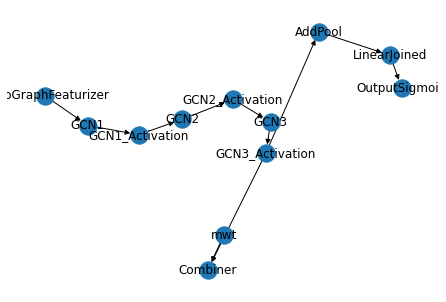

In [3]:
import networkx as nx
nx.draw(model.make_graph(), with_labels=True)

In [7]:
# Implement module forward
from typing import Dict, Union
import torch
import torch.nn
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data


CustomDatasetIn = Dict[str, Union[torch.Tensor, Data]]

class CustomModel(torch.nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        layers_dict = {}
        for layer in config.layers:
            layers_dict[layer.name] = layer.create()
        self.layers = torch.nn.ModuleDict(layers_dict)
        self.layer_configs = {
            l.type: l for l in config.layers
        }
        graph = config.make_graph()
        self.topo_sorting = nx.topological_sort(graph)
    
    def forward(self, x: CustomDatasetIn):
        outs = x.copy()
        for idx, layer_name in enumerate(self.topo_sorting):
            layer = self.layers[layer_name]
            inputs = self.layer_configs[layer_name].input
            if isinstance(inputs, str): # arrays only
                inputs = [inputs]
            inps = [ outs[input] for input in inputs ]
            if is_message_passing(layer):
                inp = inps[0]
                x, edge_index = inp.x, inp.edge_index
                outs[layer_name] = layer(x, edge_index)
            elif is_graph_pooling(layer):
                inp = inps[0]
                x, batch = inp.x, inp.batch
                outs[layer_name] = layer(x, batch)
            else: # concat layers and normal layers
                outs[layer_name] = layer(*inps)
            last = outs[layer_name]
        return last

custom_model = CustomModel(model)

In [9]:
custom_model

CustomModel(
  (layers): ModuleDict(
    (GCN1): GCNConv(30, 64)
    (GCN1_Activation): ReLU()
    (GCN2): GCNConv(64, 64)
    (GCN2_Activation): ReLU()
    (GCN3): GCNConv(64, 64)
    (GCN3_Activation): ReLU()
    (AddPool): GlobalPooling(aggr=sum)
    (Combiner): Concat()
    (LinearJoined): Linear(in_features=65, out_features=1, bias=True)
    (OutputSigmoid): Sigmoid()
  )
)

In [ ]:

dataset_input = {
    'MolToGraphFeaturizer': Data()
}